In [1]:
%pip install -U "leafmap[maplibre]"

   ---------------------------------------- 0.0/560.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/560.8 kB ? eta -:--:--
    --------------------------------------- 10.2/560.8 kB ? eta -:--:--
   ---- ---------------------------------- 61.4/560.8 kB 544.7 kB/s eta 0:00:01
   -------------- ------------------------- 204.8/560.8 kB 1.6 MB/s eta 0:00:01
   ------------------------------ --------- 430.1/560.8 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 560.8/560.8 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: leafmap
    Found existing installation: leafmap 0.46.4
    Uninstalling leafmap-0.46.4:
      Successfully uninstalled leafmap-0.46.4
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install -U "geemap[workshop]"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import leafmap.foliumap as leafmap
import matplotlib.colors as mcolors
import geopandas as gpd
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap

REPROJECT RASTER

In [5]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

raster_path = r"C:\Users\VINCENT\Downloads\WEBGIS\venv\Clip Raster Surabaya\raster_sby1.tif"
dst_crs = 'EPSG:32749'  # WGS 84
output_reprojected_path = r"C:\Users\VINCENT\Downloads\WEBGIS\venv\Clip Raster Surabaya\raster_sby1_utm49s.tif"

with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds,
        resolution=(30,30)
    )

    profile = src.profile
    profile.update(crs=dst_crs, transform=transform, width=width, height=height)

    with rasterio.open(output_reprojected_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )
print(f"Reprojected raster saved at {output_reprojected_path}")

Reprojected raster saved at C:\Users\VINCENT\Downloads\WEBGIS\venv\Clip Raster Surabaya\raster_sby1_utm49s.tif


In [6]:
import rasterio.errors
import numpy as np


class_names = {
    0 : "Vegetation",
    1 : "Water",
    2 : "Building",
    3 : "Empty Land",
    4: "Road Network"
}
class_colors = {
    "Vegetation" : '#24ff05',
    "Water"      : '#088fec',
    "Building"   : '#d64926',
    "Empty Land" : '#fffe72',
    "Road Network" : '#9c19ab'
}
try:
    with rasterio.open(output_reprojected_path) as src:
        classification_array = src.read(1)

        pixel_width = src.res[0]
        pixel_height = src.res[1]
        area_per_pixel_sqm = abs(pixel_width * pixel_height)

        raster_crs = src.crs
        print(f"Raster Coordinat System: {raster_crs}")
        print("Pixel Resolution : {pixel_width} * {pixel_height} {raster_crs.linear_units}")

        nodata_value = src.nodata
        if nodata_value is not None:
            classification_array_valid = classification_array[classification_array != nodata_value]
        else:
            classification_array_valid = classification_array

except rasterio.errors.RasterioIOError as e:
    print(f"Error: {e}")
    exit()

unique_classes, counts = np.unique(classification_array_valid, return_counts=True)
pixel_counts= dict(zip(unique_classes, counts))
print("\nNumber of Pixels per Class Value: ")
print(pixel_counts)

area_by_class_sqm = {}
for class_value, pixel_counts in pixel_counts.items():
    if class_value in class_names:
        area_sqm = pixel_counts * area_per_pixel_sqm
        area_by_class_sqm[class_names[class_value]] = area_sqm

    elif class_value == nodata_value:
        print(f"Ignore NoData pixels : {nodata_value}")
    else:
        print(f"WARNING: Class Value '{class_value}' not found in 'class_names'")


Raster Coordinat System: EPSG:32749
Pixel Resolution : {pixel_width} * {pixel_height} {raster_crs.linear_units}

Number of Pixels per Class Value: 
{np.uint8(0): np.int64(68783), np.uint8(1): np.int64(46628), np.uint8(2): np.int64(130018), np.uint8(3): np.int64(92434), np.uint8(4): np.int64(27045)}


In [7]:
import pandas as pd

df_area = pd.DataFrame(list(area_by_class_sqm.items()), columns=['Class', 'Area (m2)'])
df_area['Class_Value'] = df_area['Class'].map({v: k for k, v in class_names.items()})
df_area = df_area.sort_values(by='Class_Value').drop('Class_Value', axis=1)
total_area_sqm = df_area['Area (m2)'].sum()
df_area['Percentage (%)'] = (df_area['Area (m2)'] / total_area_sqm) * 100
df_area['Area (Ha)'] = df_area['Area (m2)']/10000
df_area['Area (km2)'] = df_area['Area (m2)']/1000000

print(f"\nResults of Calculation of Area and Percentage of Land Cover: ")
print(df_area.round(2))


Results of Calculation of Area and Percentage of Land Cover: 
          Class    Area (m2)  Percentage (%)  Area (Ha)  Area (km2)
0    Vegetation   61904700.0           18.85    6190.47       61.90
1         Water   41965200.0           12.78    4196.52       41.97
2      Building  117016200.0           35.63   11701.62      117.02
3    Empty Land   83190600.0           25.33    8319.06       83.19
4  Road Network   24340500.0            7.41    2434.05       24.34


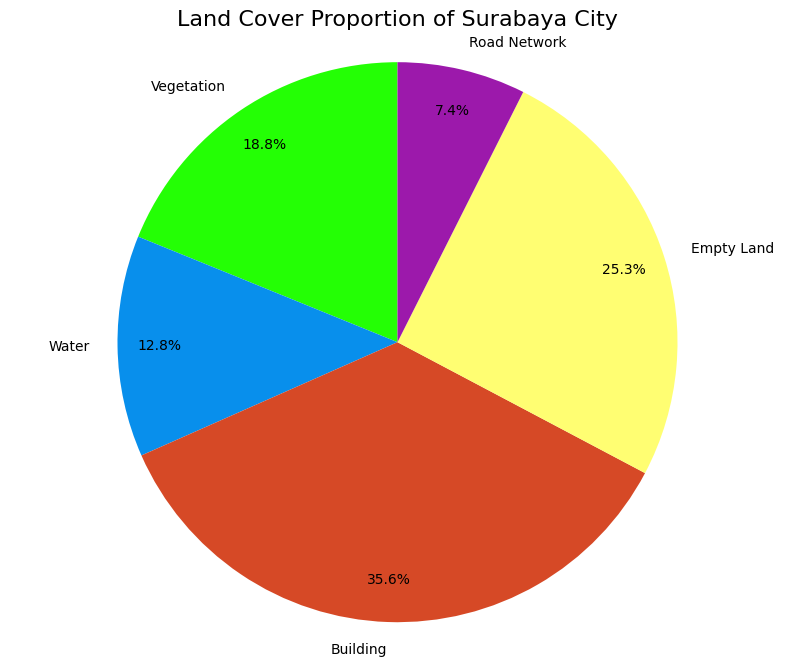

<Figure size 640x480 with 0 Axes>

In [8]:
plot_colors = [class_colors[c] for c in df_area['Class']]

plt.figure(figsize=(10,8))
plt.pie(
    df_area['Percentage (%)'],
    labels=df_area['Class'],
    autopct= '%1.1f%%',
    colors= plot_colors,
    startangle= 90,
    pctdistance= 0.85,
    textprops= {'fontsize' : 10} 
)
plt.title('Land Cover Proportion of Surabaya City', fontsize= 16)
plt.axis('equal')
plt.show()
plt.savefig(r"C:\Users\VINCENT\Downloads\WEBGIS\Pie_Chart_SBY.png", dpi=300, bbox_inches= 'tight')




In [9]:
GEE_Project_ID = 'elfonda2002'

try:
    ee.Initialize(project= GEE_Project_ID)
    print(f"GEE Initialize Succesfully")

except Exception as e:
    print(f"Error initializing GEE: {e}")
    exit()

GEE Initialize Succesfully


In [10]:
try:
    asset = ee.Image('projects/elfonda2002/assets/raster_sby1_utm49s')
    info = asset.getInfo()
    print("Asset info:", info)
except Exception as e:
    print("Gagal akses asset:", e)

Asset info: {'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [944, 591], 'crs': 'EPSG:32749', 'crs_transform': [30, 0, 675651.6717140566, 0, -30, 9204690.537295068]}], 'version': 1748056227612692, 'id': 'projects/elfonda2002/assets/raster_sby1_utm49s', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[112.84706418760439, -7.191179569671734], [112.84703009484477, -7.191177597535317], [112.59090881549719, -7.192138629664174], [112.59078377742112, -7.192248743970365], [112.59064591724307, -7.1923425529691345], [112.59063755105758, -7.192386903324239], [112.5912011772006, -7.352459055974274], [112.59131230190958, -7.352583121900537], [112.59140678518484, -7.352719920947608], [112.5914403408409, -7.352726077301739], [112.59147435117964, -7.352728129936891], [112.8476865848013, -7.351745440293619], [112.84781159149088, -7.351635237065018], [112.84794941702847, -7.351541409683958], [11

In [11]:
m = geemap.Map(center=(-7.25, 112.75), zoom=10)

m.add_basemap("OpenStreetMap")
m.add_basemap("TERRAIN")
m.add_basemap("SATELLITE")


shp_path = r"C:\Users\VINCENT\OneDrive\문서\Latihan mapping\KOTA SURABAYA (1)\KOTA SURABAYA\ADMINISTRASIDESA_AR_25K.shp"
gdf = gpd.read_file(shp_path)

m.add_gdf(
    gdf,
    layer_name="Batas Administrasi",
    style={
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.0
    }
)

colors_hex = ['#24ff05', '#088fec', '#d64926', '#fffe72', '#9c19ab']
vis_params = {
    'min': 0,
    'max': len(colors_hex) - 1,
    'palette': colors_hex
}

gee_asset = ee.Image('projects/elfonda2002/assets/raster_sby1_utm49s')

m.addLayer(
    gee_asset,
    vis_params,
    'Land Cover Classification of Surabaya, 2024',
    opacity=0.4
)

m.add_legend(
    title="Land Cover Classification of Surabaya, 2024",
    legend_dict={
        "Vegetation": '#24ff05',
        "Water": '#088fec',
        "Building": '#d64926',
        "Empty Land": '#fffe72',
        "Road Network": '#9c19ab'
    }
)
m


Map(center=[-7.25, 112.75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [13]:
output_html = m.to_html(r"C:\Users\VINCENT\Downloads\WEBGIS\index.html")